In [26]:
import hdbscan
from matplotlib import pylab
import pymongo as pm
import numpy as np
import json
import csv
from geopy import distance
from descartes import PolygonPatch

Connect to Databases

In [3]:
connection = pm.MongoClient()
buffalo = connection.buffalo

Read in data

In [ ]:
def readGeoJson(FILE_PATH):
    with open(FILE_PATH, 'r') as f:
        return json.load(f)

In [ ]:
def ingestGeoJsonFeatureToMongoDB(geojson, collection):
    for feature in geojson['features']:
        collection.insert_one(feature)

In [ ]:
def readCSV(FILE_PATH):
    CSV = []
    with open(FILE_PATH, 'r') as F:
        CSV = list(csv.reader(F, quotechar='"', delimiter=','))
    return np.array(CSV)

In [ ]:
directory = "/home/apjansing/Documents/Hack Upstate/huxi-buffalo-crimedata/data/"
camerasData = readGeoJson(directory+"Buffalo Police Department Camera Locations.geojson")
policeDistricts = readGeoJson(directory+"Police Districts.geojson")
streetsData = readGeoJson(directory+"Streets.geojson")
crimeData = readCSV(directory+"Crime_Incidents.csv")

Ingest data to Collections

In [ ]:
buffalo.cameras.drop()
buffalo.cameras.create_index([("geometry",  "2dsphere")])
ingestGeoJsonFeatureToMongoDB(camerasData, buffalo.cameras)

In [ ]:
buffalo.districts.drop()
buffalo.districts.create_index([("geometry", "2dsphere")])
ingestGeoJsonFeatureToMongoDB(policeDistricts, buffalo.districts)

In [ ]:
buffalo.streets.drop()
buffalo.streets.create_index([("geometry", "2dsphere")])
ingestGeoJsonFeatureToMongoDB(streetsData, buffalo.streets)

In [ ]:
def getJson(keys, values):
    payload = {}
    for i,j in zip(keys,values):
        try:
            payload[i] = float(j)
        except:
            payload[i] = j   
    return payload

In [ ]:
'''
['incident_id' 'case_number' 'incident_datetime' 'incident_type_primary'
 'incident_description' 'clearance_type' 'address_1' 'address_2' 'city'
 'state' 'zip' 'country' 'latitude' 'longitude' 'created_at' 'updated_at'
 'location' 'hour_of_day' 'day_of_week' 'parent_incident_type']
 '''
buffalo.crimes.drop()
buffalo.crimes.create_index([("location", pm.GEO2D)])
keys = crimeData[0]
# print keys
for i in range(1, len(crimeData)):
    payload = getJson(keys, crimeData[i])
    payload['location'] = str(payload['longitude']) + ',' + str(payload['latitude'] )
    buffalo.crimes.insert_one(payload)

Find some metrics about the streets.

In [ ]:
'''
Knowing that you're receiving location points as (long, lat) and you need to swap them.
'''
def getLength(loc1, loc2):
    return distance.distance((loc1[1], loc1[0]), (loc2[1], loc2[0])).miles

In [ ]:
cursor = buffalo.streets.find()
while cursor.alive:
    length = 0
    token = cursor.next()
    coords = token['geometry']['coordinates']
    for i in range(len(coords)):
        for j in range(len(coords[i])):
            for k in range(j+1, len(coords[i])):
                length += getLength(coords[i][j], coords[i][k])
    buffalo.streets.update_one( {"_id":token['_id']}, {"$set": { "streetLength": length }} )


Find where and how close the closest police camera is

In [ ]:
cursor = buffalo.crimes.find()
i = 0
while cursor.alive:
    i += 1
    if i % 5000 == 0:
        print i, " tokens processed..."
    token = cursor.next()
    loc = token['location'].split(',')
    loc[0] = float(loc[0])
    loc[1] = float(loc[1])
    near = {"geometry": {"$near": {"$geometry": {"type": "Point" ,"coordinates": loc } } } }
    near = buffalo.cameras.find(near).limit(1).next()
    nearLoc = near['geometry']['coordinates']
    closestCamera = distance.distance((nearLoc[1], nearLoc[0]), (loc[1], loc[0])).miles
    buffalo.crimes.update_one( {"_id":token['_id']}, {"$set": { "closestCamera": closestCamera }} )

Create clusters of crimes committed

In [15]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, metric='haversine')

In [10]:
cursor = buffalo.crimes.find({"closestCamera": {"$gt": 0.5, "$lt":1.0}})
data = []
while cursor.alive:
    token = cursor.next()['location'].split(',')
    token[0] = float(token[0])
    token[1] = float(token[1])
    data += [token]
print len(data)
data = np.array(data)
print data

4941
[[-78.79952783  42.89645133]
 [-78.8564296   42.95844343]
 [-78.81519299  42.83212177]
 ...
 [-78.90211807  42.93953735]
 [-78.80782401  42.83777086]
 [-78.80106784  42.93107611]]


In [96]:
cursor = buffalo.crimes.find()
D = []
while cursor.alive:
    token = cursor.next()['location'].split(',')
    token[0] = float(token[0])
    token[1] = float(token[1])
    D += [token]
print len(D)
D = np.array(D)
print D

139614
[[-78.88077999  43.00648972]
 [-78.8696143   42.9586953 ]
 [-79.02768538  42.63373581]
 ...
 [-78.80998689  42.86847088]
 [-78.86978316  42.94900683]
 [-78.83558514  42.88885932]]


In [11]:
print data
print len(data)

[[-78.79952783  42.89645133]
 [-78.8564296   42.95844343]
 [-78.81519299  42.83212177]
 ...
 [-78.90211807  42.93953735]
 [-78.80782401  42.83777086]
 [-78.80106784  42.93107611]]
4941


In [12]:
def getClusters(cluster_labels):
    cluster_labels_and_ids = np.array(zip(cluster_labels, airIDs))
    M = max(cluster_labels)
    clusters = []
    for i in range(M+1):
        iThCluster = []
        for e in cluster_labels_and_ids:
            if e[0] == str(i):
                iThCluster += [e[1]]
        clusters += [iThCluster]
    return clusters

In [100]:
def plotStuff(x, name="bar.png", labels = np.array([]), showPlot = True):
    xT = x.T
    fig = pylab.figure(figsize=(100,100))
    cursor = buffalo.districts.find()
    while cursor.alive:
        token = cursor.next()
        xy = np.array(token['geometry']['coordinates'][0][0]).T
        pylab.scatter(xy[0],xy[1])
    if len(labels) != 0:
        pylab.scatter(xT[0], xT[1], c=labels)
    else:
        pylab.scatter(xT[0], xT[1])
    pylab.savefig(name)
    if showPlot:
        pylab.show()

SyntaxError: invalid syntax (<ipython-input-100-7bb42666fdb3>, line 13)

clustering done


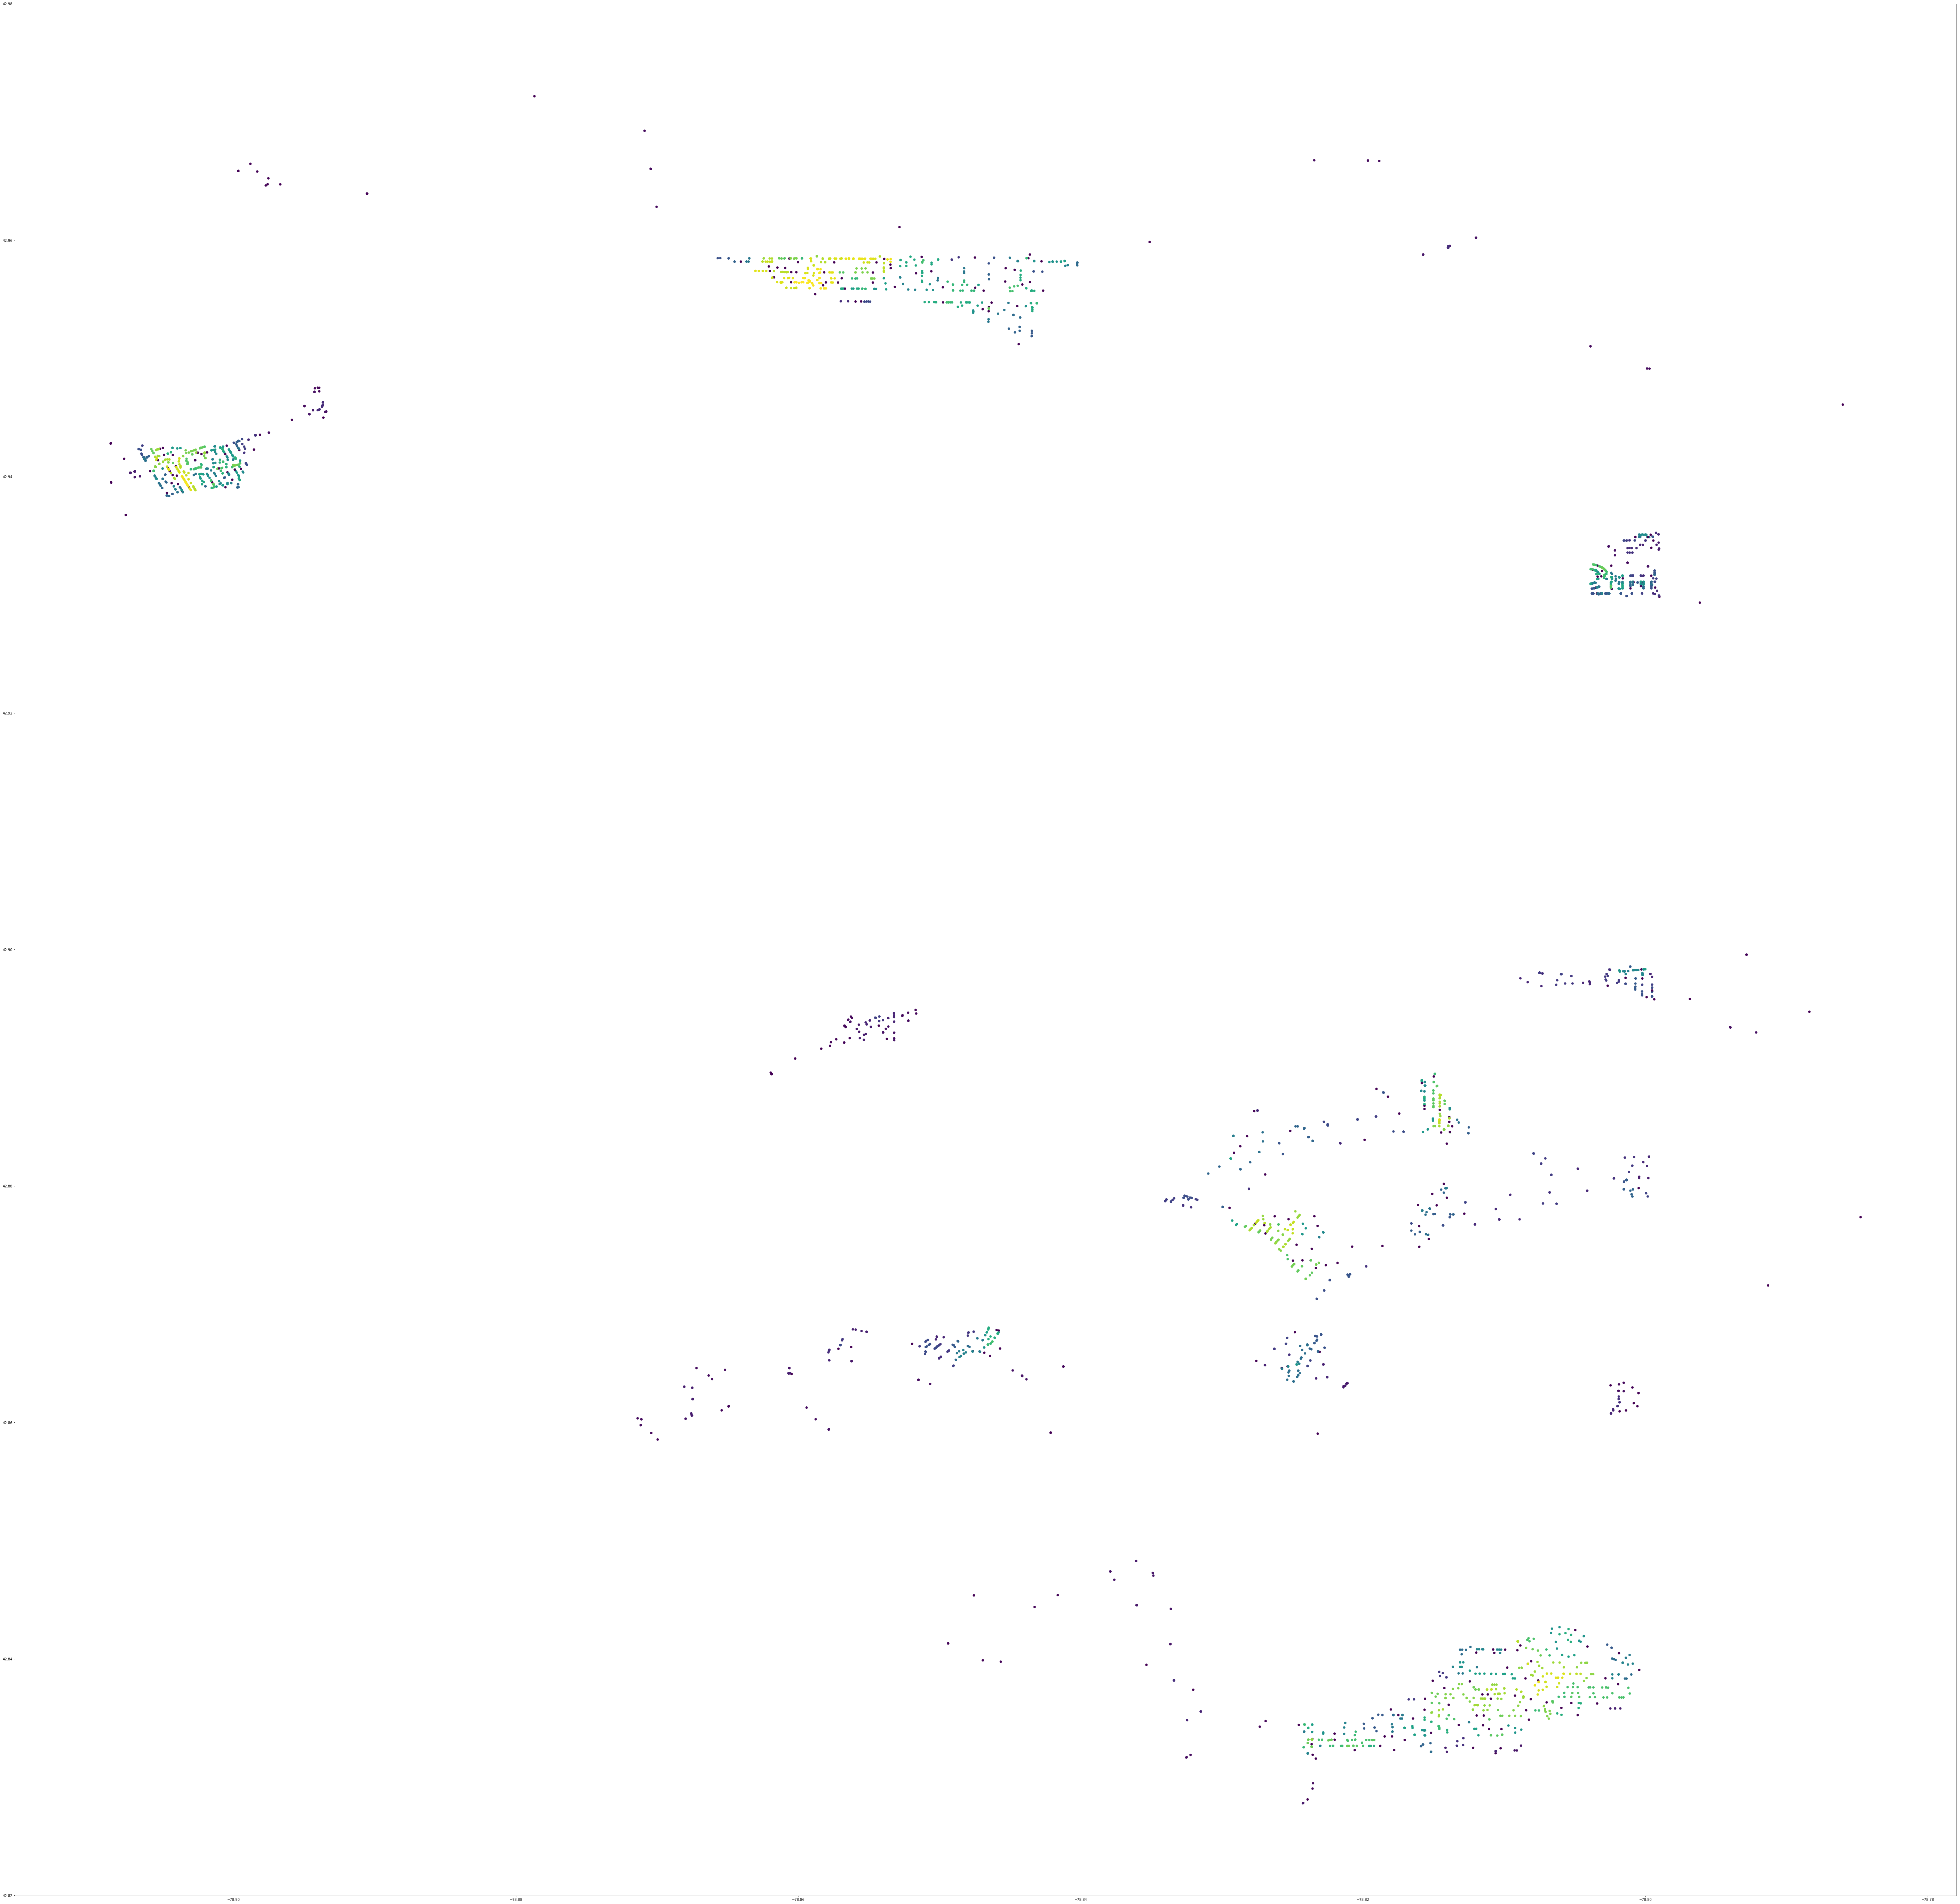

In [87]:
# rads = np.radians(data)
# print 'rads done'
cluster_labels = clusterer.fit_predict(data)
print 'clustering done'
plotStuff(data, "crimes.png", labels=cluster_labels, showPlot=True)

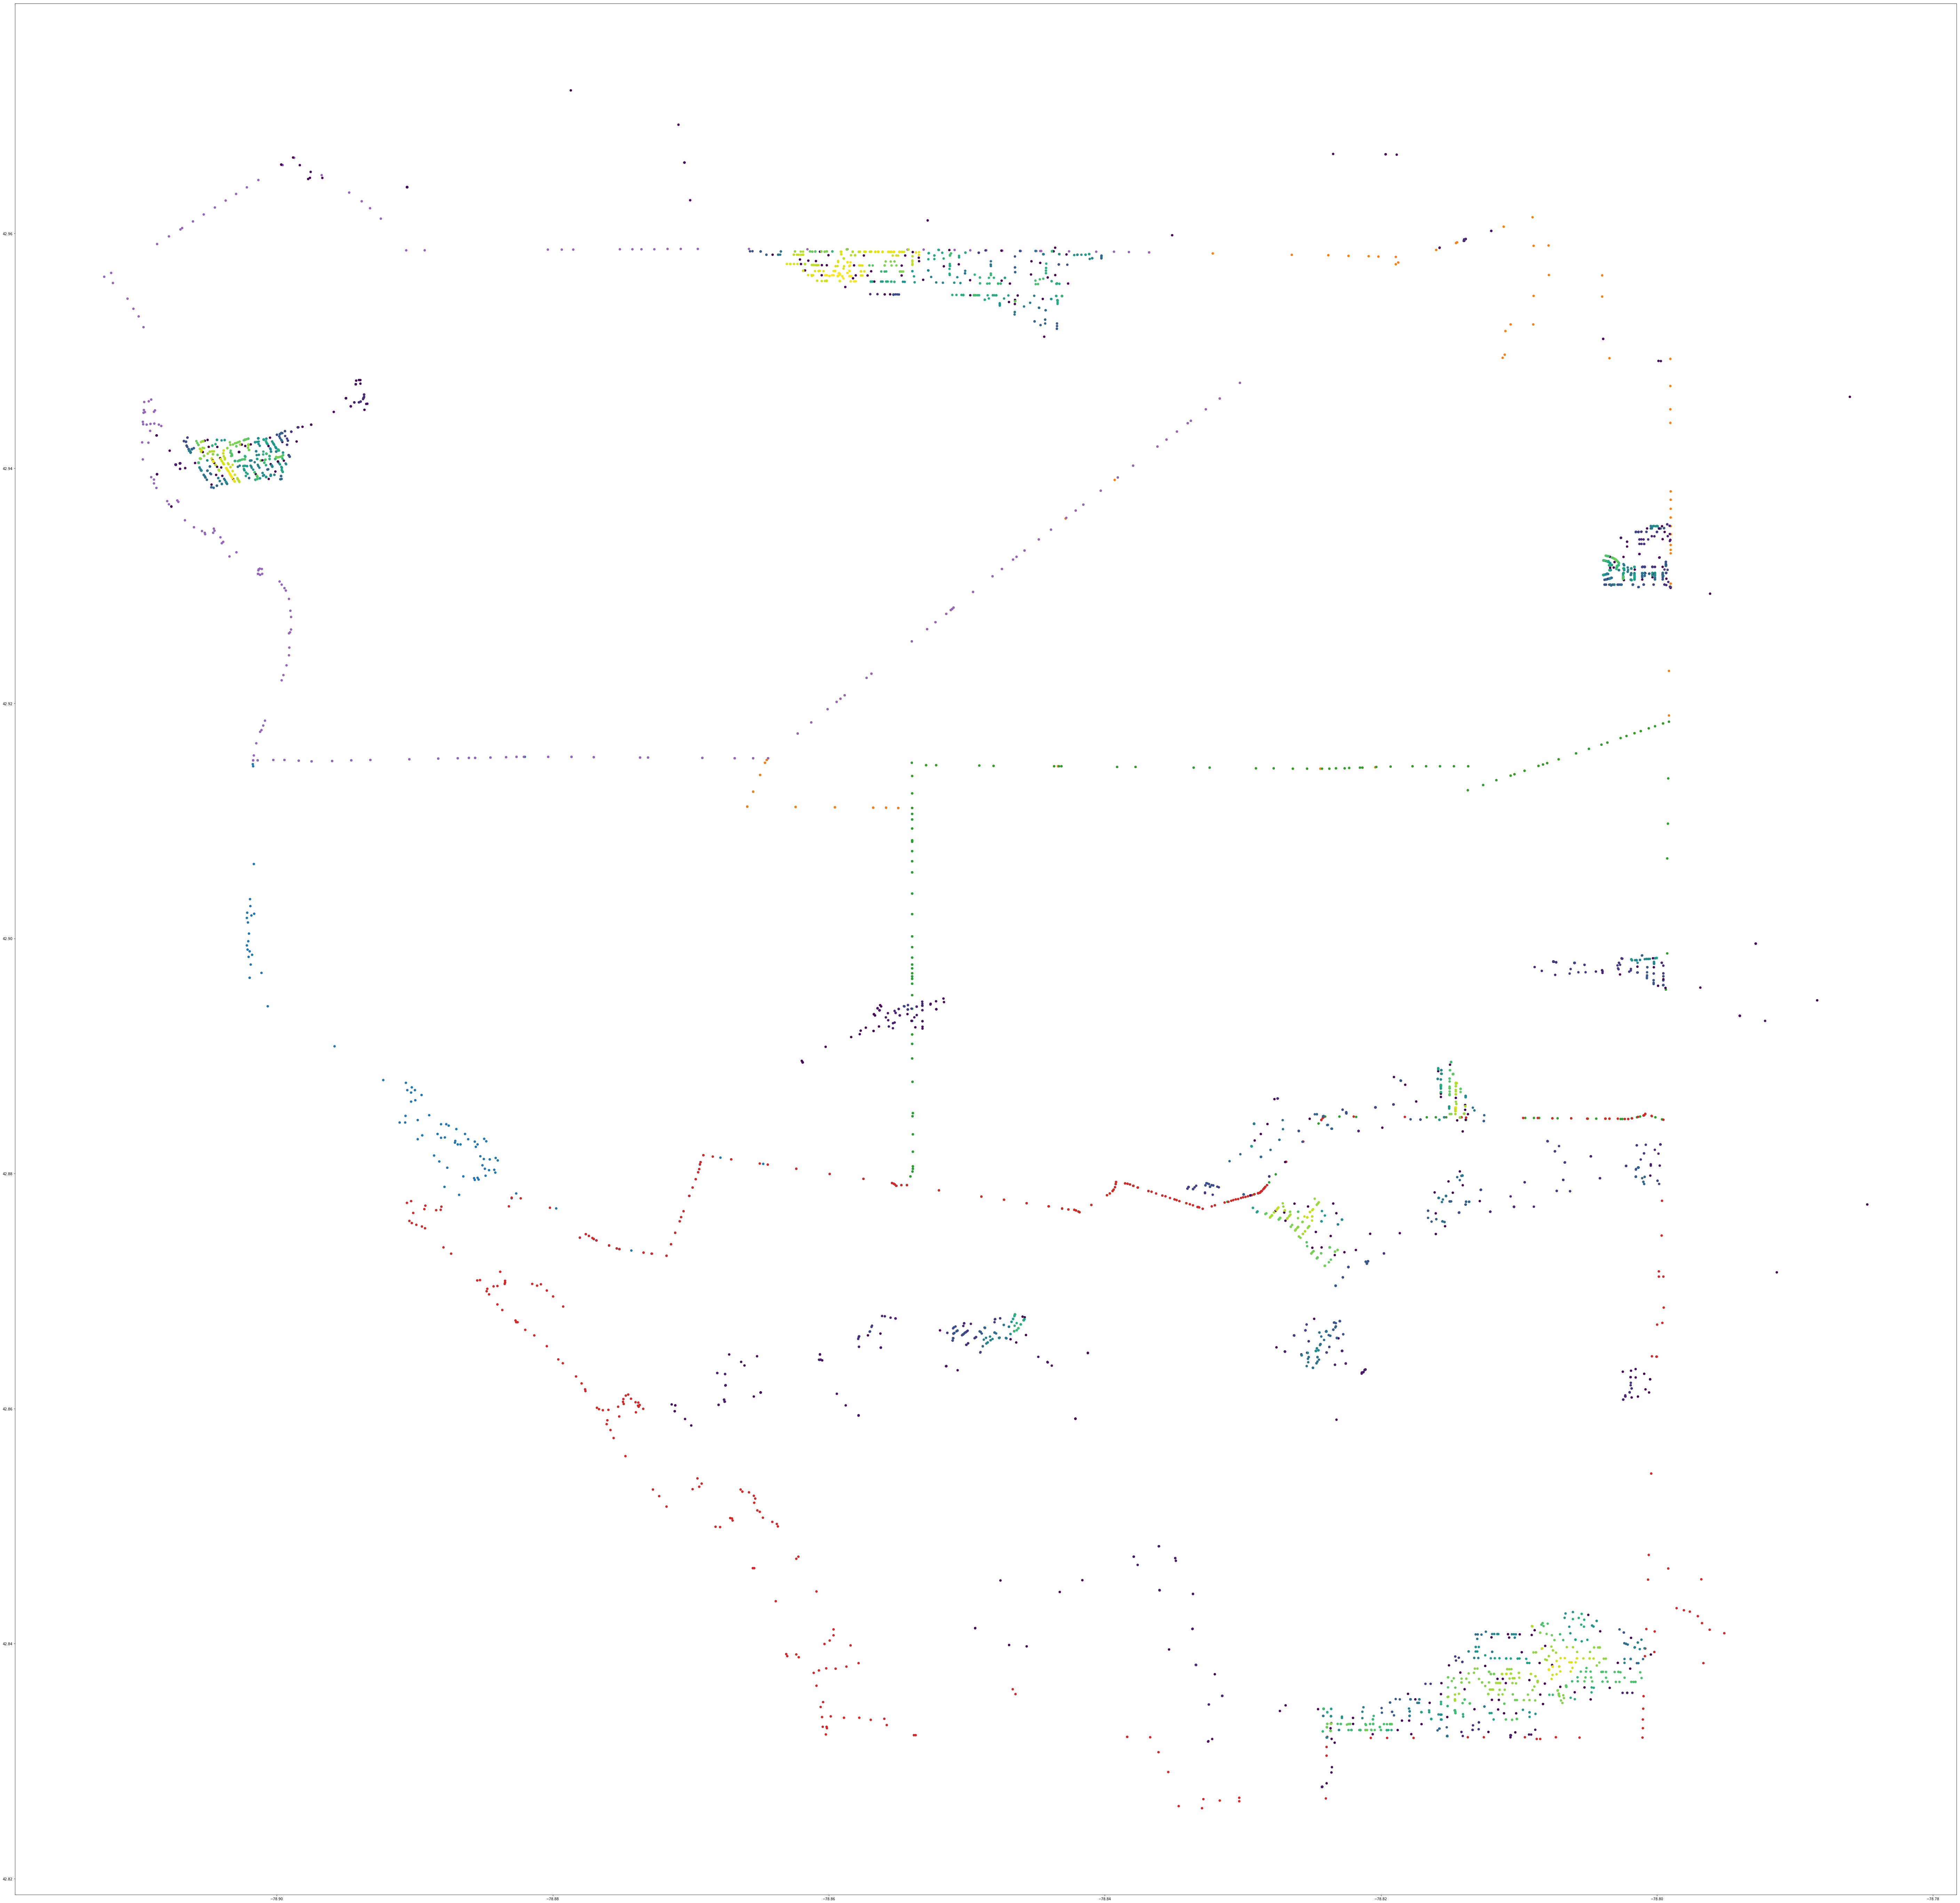

In [94]:
plotStuff(data, "crimes.png", labels=cluster_labels, showPlot=True)

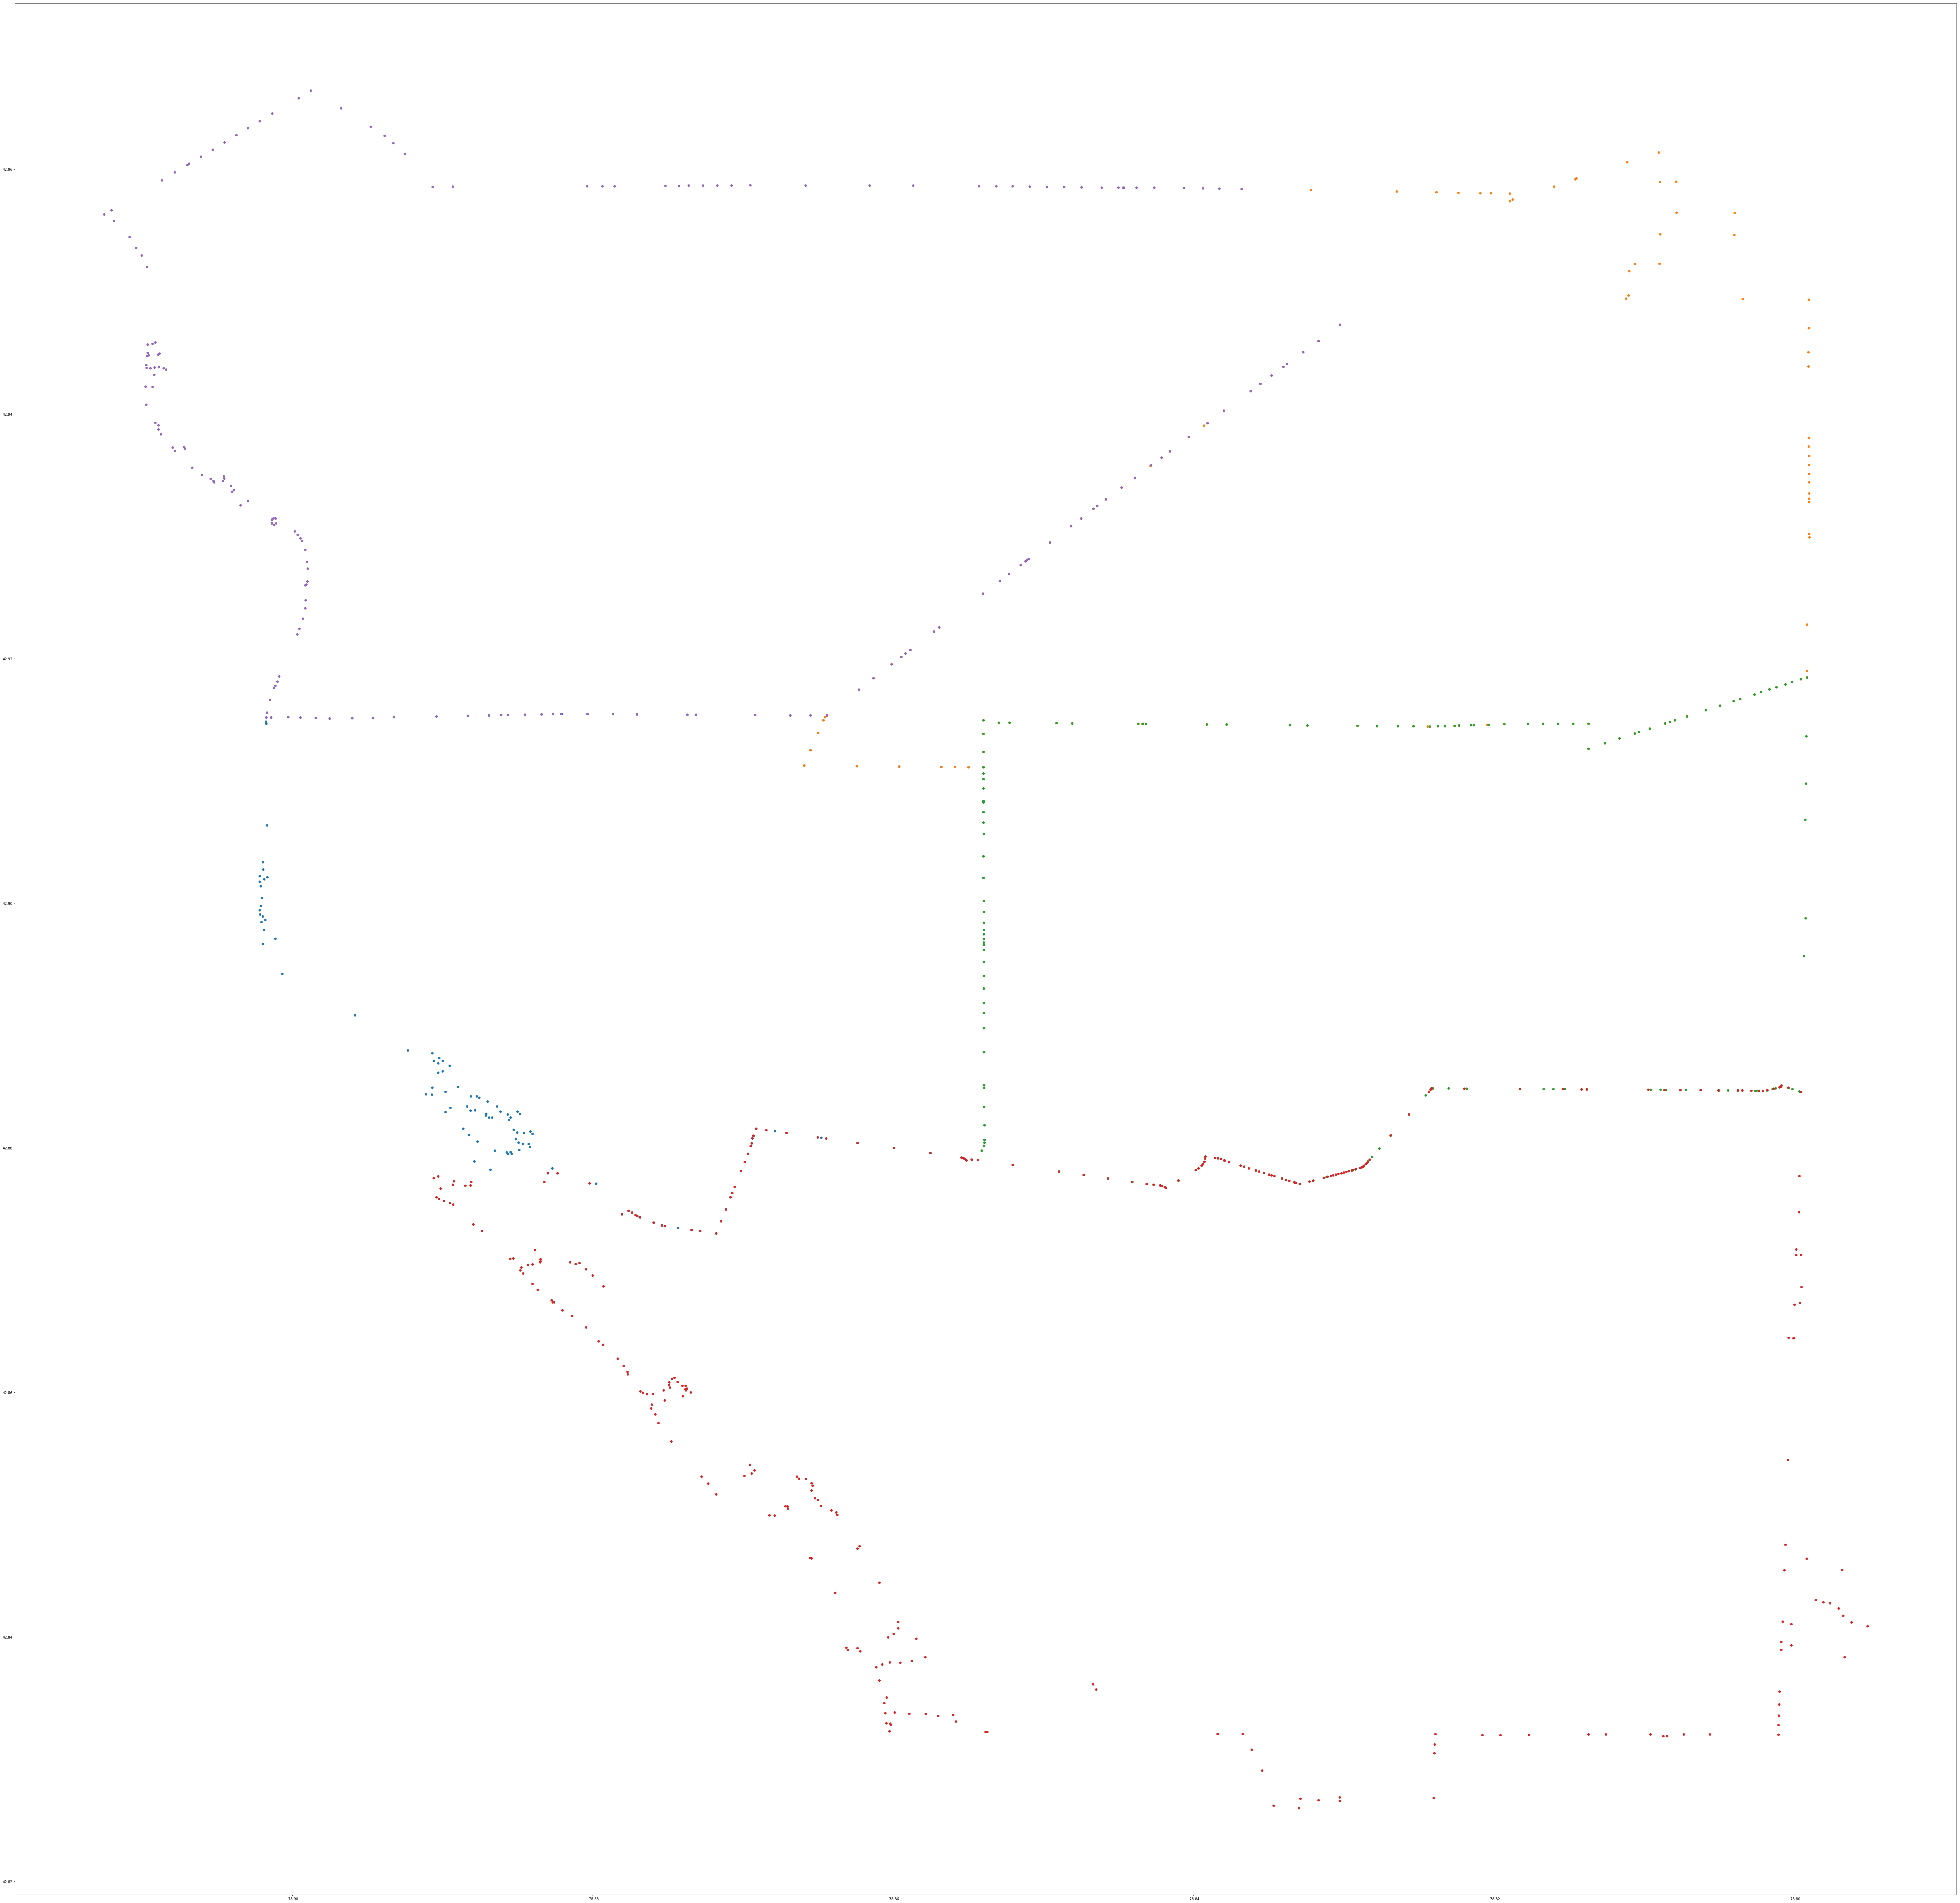

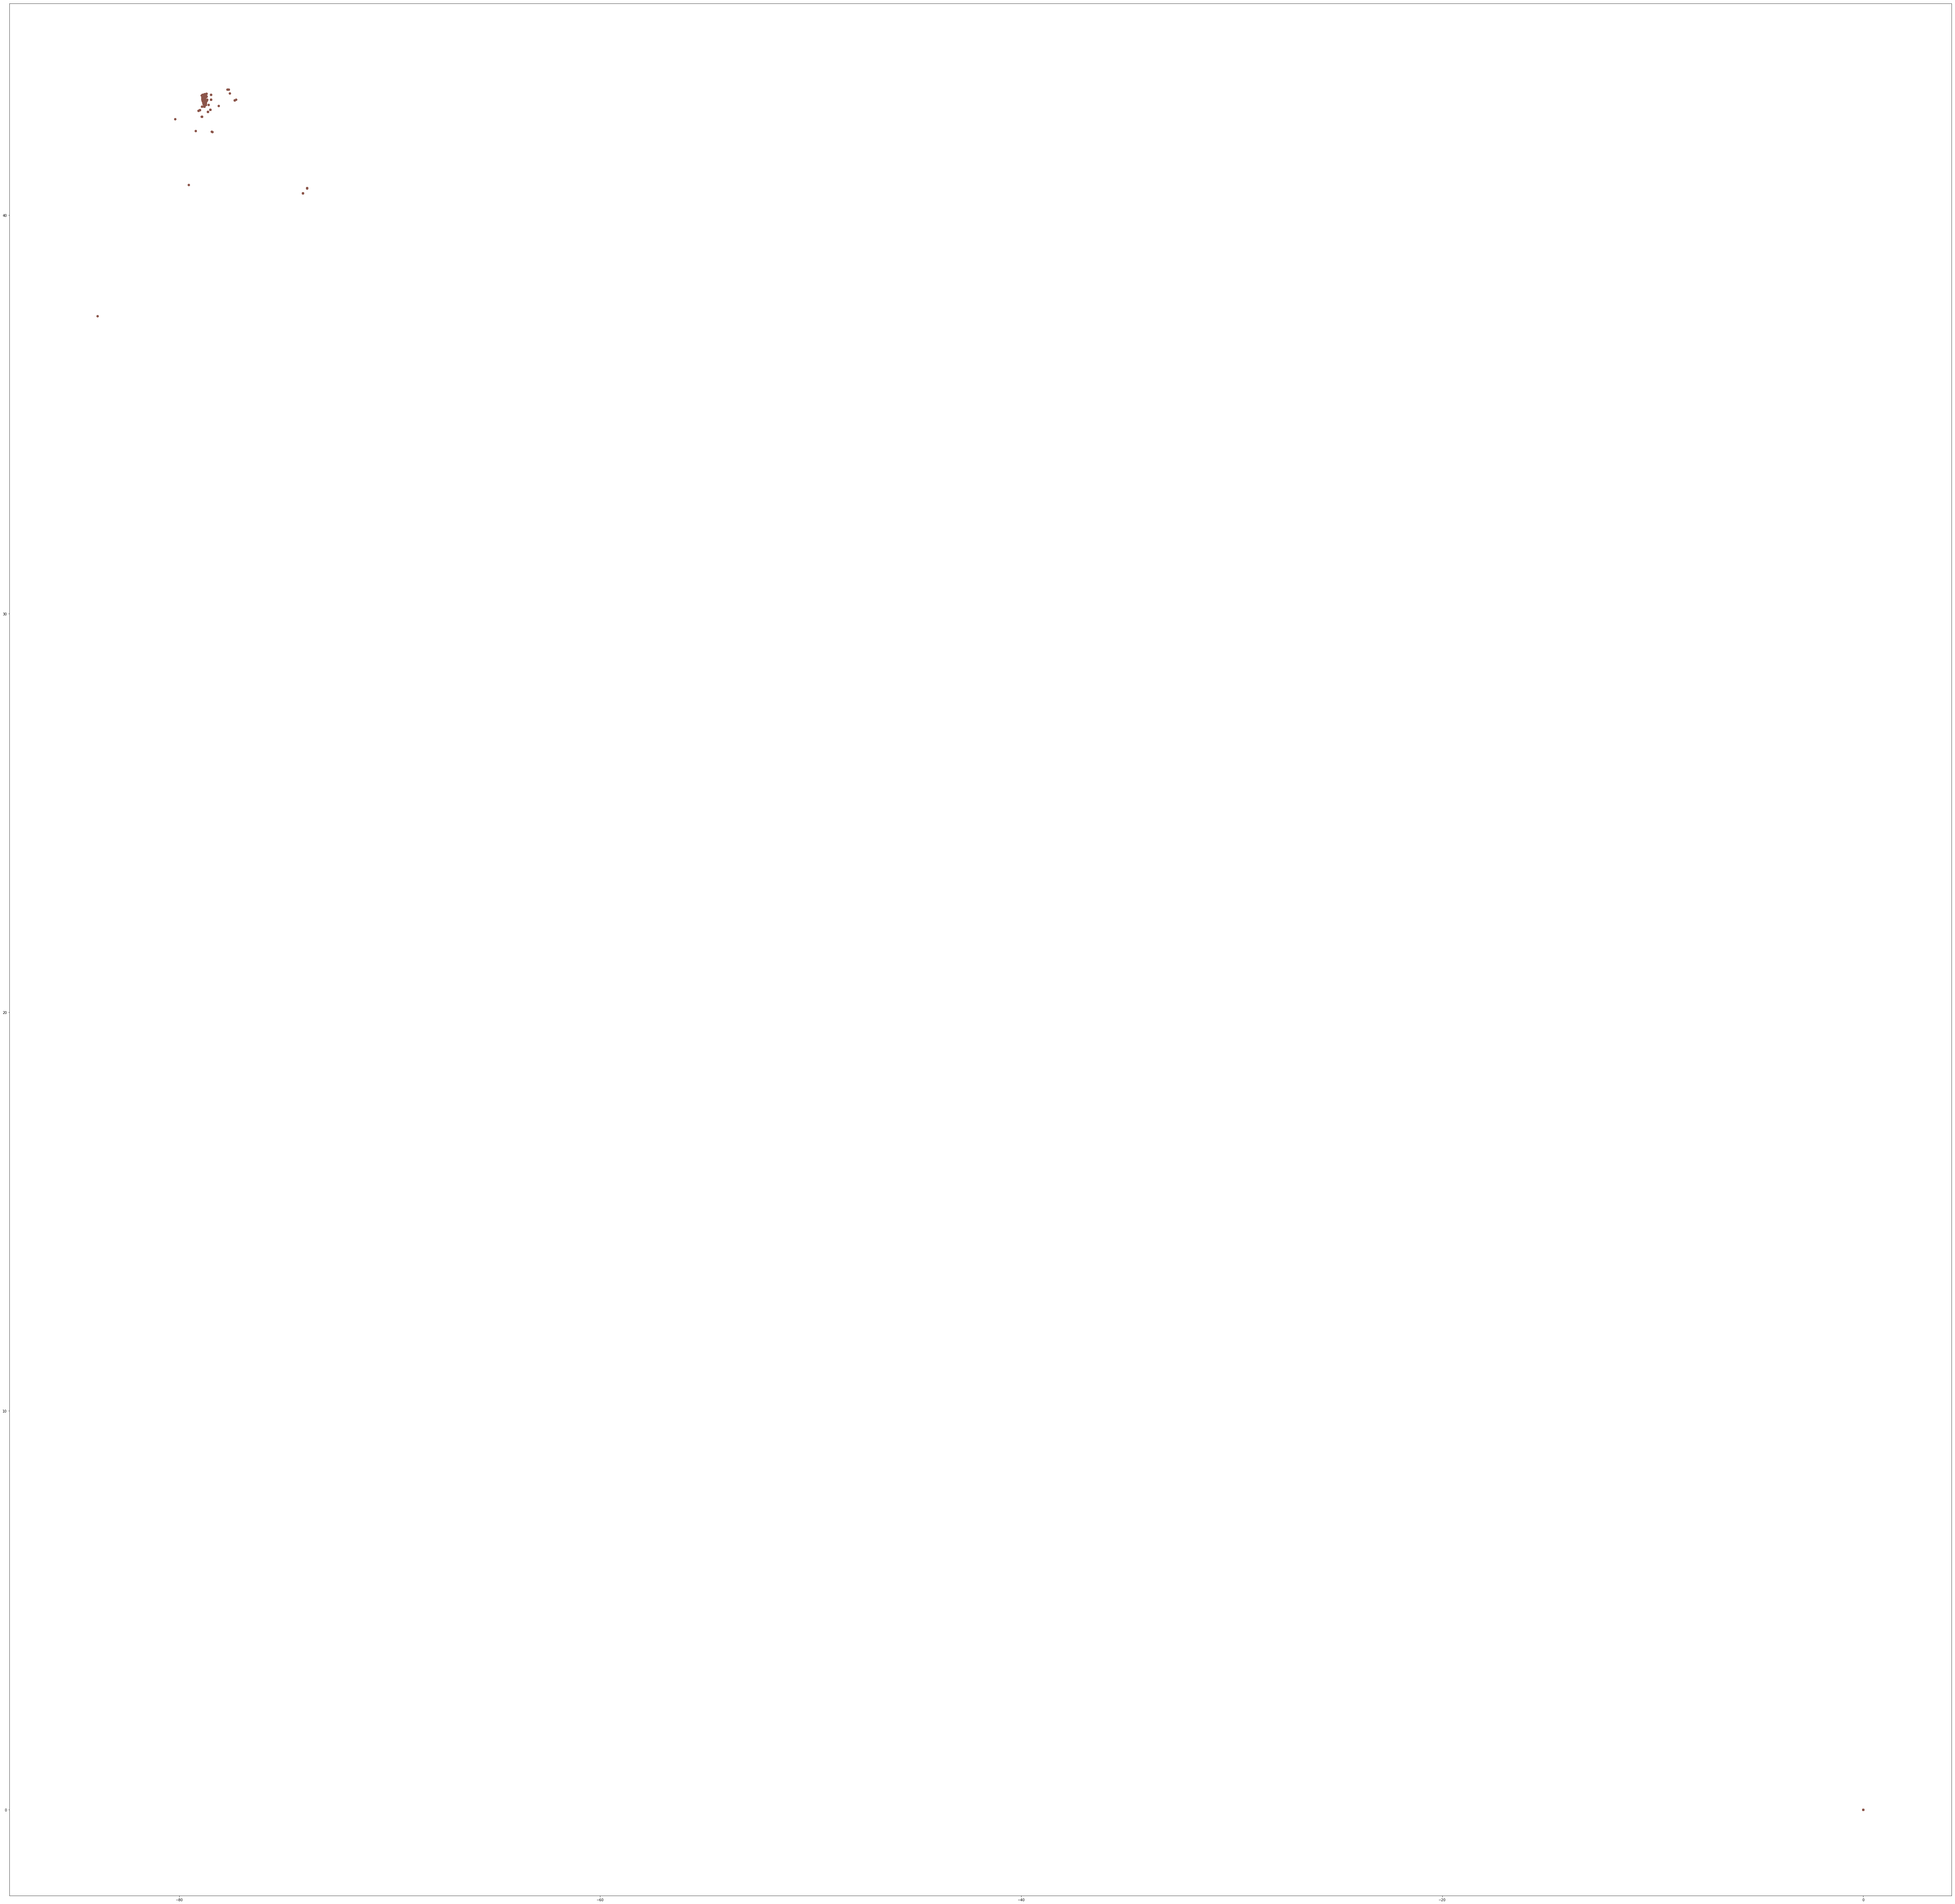

In [99]:
plotStuff(D, "crimesUNFILTERED.png", showPlot=True)